# 引入函式庫

In [1]:
import os
import cv2
import scipy.io
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img,img_to_array
import matplotlib.pyplot as plt

# 載入資料集

In [2]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 13.65 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.
Updating files: 100% (4202/4202), done.


In [3]:
# 設定資料集路徑
image_folder = 'clothing-co-parsing/photos/'
annotation_folder = 'clothing-co-parsing/annotations/pixel-level/'

# 統一圖片大小
IMAGE_SIZE = (220,148)

# 讀出所有檔案的路徑
input_image_folder = sorted([os.path.join(image_folder, fileName) for fileName in os.listdir(image_folder) if fileName.endswith('.jpg')])
target_annotation_folder = sorted([os.path.join(annotation_folder, fileName) for fileName in os.listdir(annotation_folder) if fileName.endswith('.mat')])

讀jpg

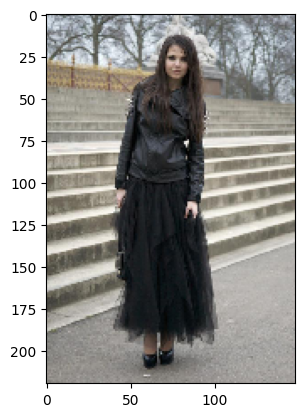

In [4]:
def path_to_input_image(path):  #把一個path的圖片讀出為np array
    return img_to_array(load_img(path,target_size=IMAGE_SIZE)).astype('uint8')

images = []
for path in input_image_folder:
    images.append(path_to_input_image(path))
images = np.stack(images)
images = images/255.0
images.shape

plt.imshow(images[1]) #測試看看

讀mat

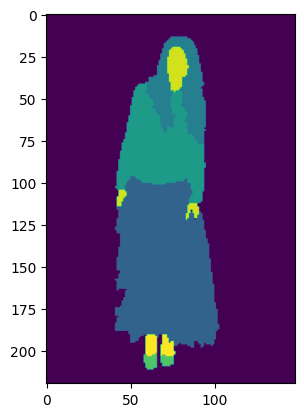

In [5]:
annotations = []

for i in range(len(target_annotation_folder)):
    currentFile = scipy.io.loadmat(target_annotation_folder[i])
    labelImage = currentFile['groundtruth']
    labelImage = cv2.resize(labelImage, (IMAGE_SIZE[1],IMAGE_SIZE[0]), interpolation=cv2.INTER_NEAREST)
    labelImage.dtype = 'uint8'
    annotations.append(labelImage)
annotations = np.stack(annotations)
annotations = np.expand_dims(annotations, axis=-1)
annotations.shape
plt.imshow(annotations[1,:,:,0]) #測試看看

分割資料集

In [6]:
np.random.seed(9999)
idx = np.random.permutation(1000) + 1
training_idx = idx[:700]
validation_idx = idx[700:750]
testing_idx = idx[750:]

train_images = images[training_idx]
train_annotations = annotations[training_idx]

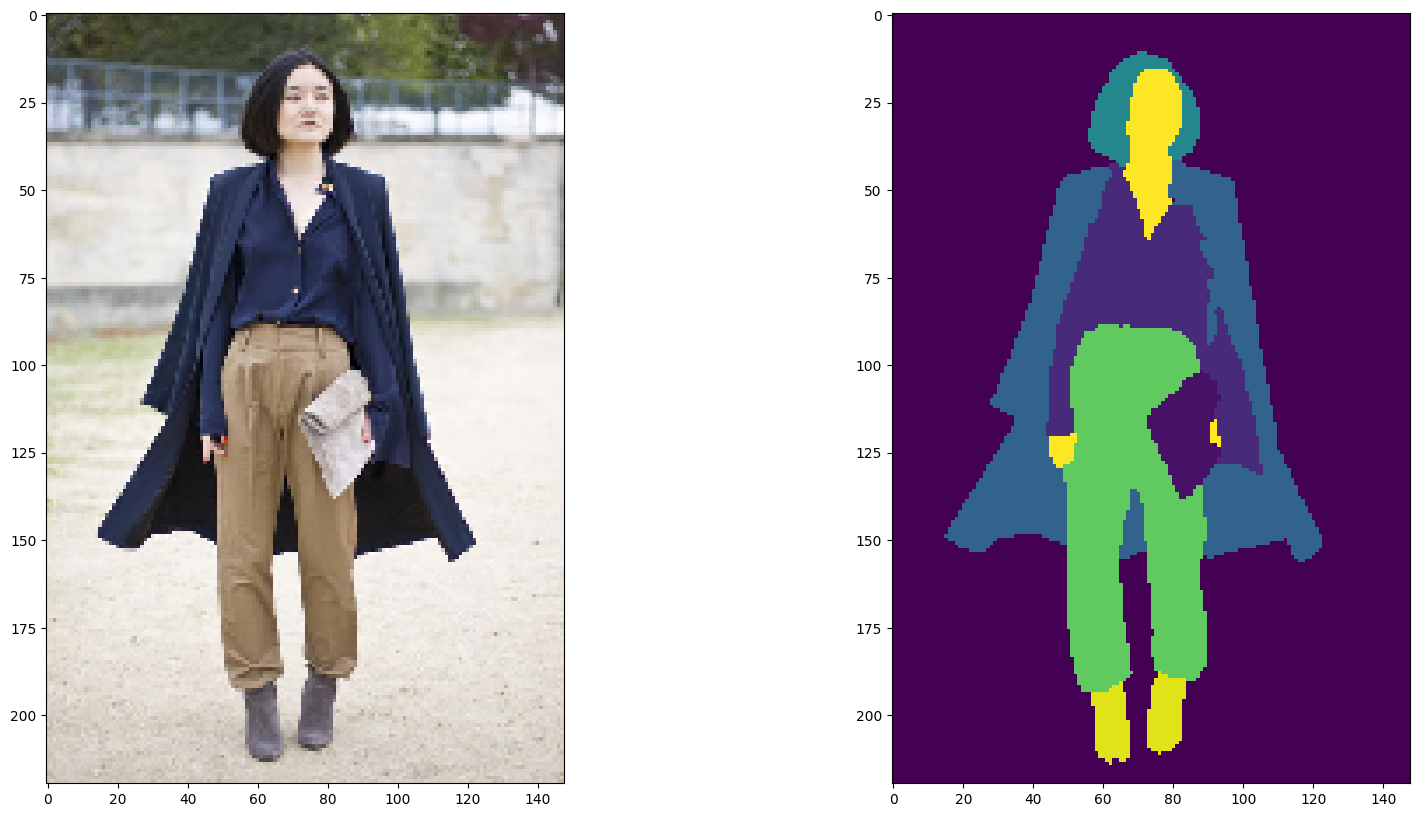

In [7]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(train_images[100])
plt.subplot(1,2,2)
plt.imshow(train_annotations[100,:,:,0])

In [8]:
# 切validation set
validation_image = images[validation_idx]
validation_annotation = annotations[validation_idx]
print(validation_image.shape)
print(validation_annotation.shape)

(50, 220, 148, 3)
(50, 220, 148, 1)


In [9]:
# 切test set
test_image = images[testing_idx]
test_annotation = annotations[testing_idx]
print(test_image.shape)
print(test_annotation.shape)

(250, 220, 148, 3)
(250, 220, 148, 1)


# 建立並訓練語義分割模型

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, UpSampling2D

inputs = keras.Input(shape=IMAGE_SIZE+(3,))
x = layers.Conv2D(128, 3, strides=2,activation='relu',padding='same')(inputs)
x = layers.Conv2D(128, 3,activation='relu',padding='same')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(256, 3, strides=2, activation='relu',padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu',padding='same')(x)
x = layers.Conv2D(512, 3,padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation='relu')(x)
x = layers.Conv2DTranspose(512, 3, activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(256, 3,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(256, 1,strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(128, 3,activation='relu',padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2DTranspose(128, 1,strides=2,activation='relu',padding='same')(x)
outputs = layers.Conv2D(59,3,activation='softmax',padding='same')(x)
model = keras.Model(inputs,outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 148, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 110, 74, 128)      3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 74, 128)      147584    
                                                                 
 dropout (Dropout)           (None, 110, 74, 128)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 37, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 37, 256)       590080    
                                                                 
 conv2d_4 (Conv2D)           (None, 55, 37, 512)       118016

In [11]:
def get_mask(pred):
    return np.expand_dims(np.argmax(pred,axis=-1), axis=-1)

#展現成果用
def display_mask(pred):
    mask = np.argmax(pred,axis=-1)
    plt.imshow(mask)

1/1 [==============================] - 0s 23ms/step


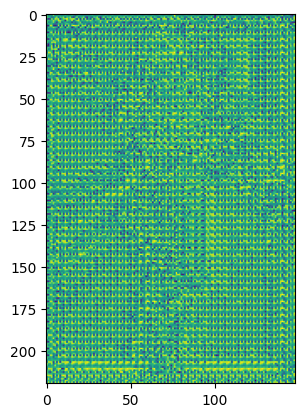

In [12]:
model.predict(train_images[np.newaxis,0]).shape
np.sum(model.predict(train_images[np.newaxis,0])[0,10,1,:])
display_mask(model.predict(train_images[np.newaxis,0])[0])

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("mySegmentationNetwork.keras",save_best_only=True,monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)]

In [14]:
history = model.fit(train_images,train_annotations,
                    callbacks=callbacks,
                    epochs=100,
                    batch_size=64,
                    validation_data=(validation_image,validation_annotation))

Epoch 1/100
11/11 [==============================] - 99s 6s/step - loss: 2.4755 - accuracy: 0.5352 - val_loss: 1.9458 - val_accuracy: 0.7775
Epoch 2/100
11/11 [==============================] - 15s 1s/step - loss: 1.2126 - accuracy: 0.7682 - val_loss: 2.8119 - val_accuracy: 0.7775
Epoch 3/100
11/11 [==============================] - 15s 1s/step - loss: 1.0742 - accuracy: 0.7686 - val_loss: 2.3239 - val_accuracy: 0.7775
Epoch 4/100
11/11 [==============================] - 15s 1s/step - loss: 1.0196 - accuracy: 0.7686 - val_loss: 2.8067 - val_accuracy: 0.7775
Epoch 5/100
11/11 [==============================] - 15s 1s/step - loss: 1.0092 - accuracy: 0.7686 - val_loss: 2.7153 - val_accuracy: 0.7775
Epoch 6/100
11/11 [==============================] - 15s 1s/step - loss: 0.9990 - accuracy: 0.7686 - val_loss: 2.3362 - val_accuracy: 0.7775
Epoch 7/100
11/11 [==============================] - 15s 1s/step - loss: 0.9910 - accuracy: 0.7686 - val_loss: 2.3919 - val_accuracy: 0.7775
Epoch 8/100
1

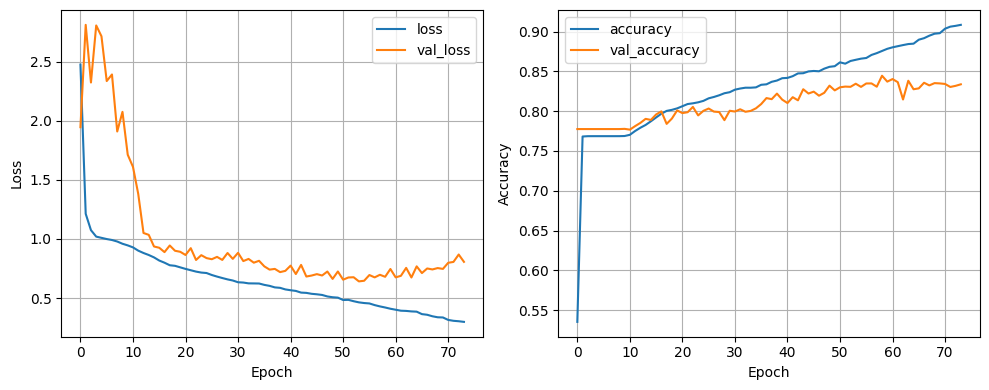

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 計算測試圖像的平均IoU

In [16]:
test_set_count = test_annotation.shape[0]
test_model = keras.models.load_model('mySegmentationNetwork.keras')
test_loss, test_accuracy = test_model.evaluate(test_image,test_annotation)
test_model_predicted = test_model.predict(test_image)

8/8 [==============================] - 2s 188ms/step


顯示三個測試分割影像成果

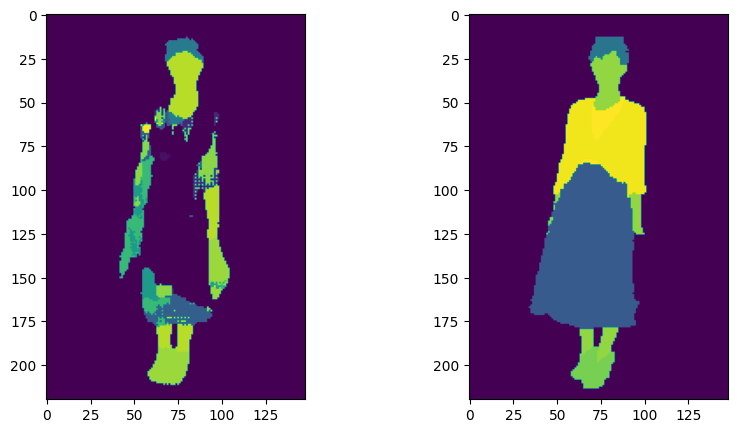

average iou: 0.16810465148091316
max_iou: 0.2986067
min_iou: 0.08116162


In [17]:
import matplotlib.pyplot as plt
show_size = 250
sum_iou = 0
test_model_predicted_mask = []

max_iou_index = 0
max_iou = 0
min_iou_index = 0
min_iou = 100

for predicted in test_model_predicted:
  test_model_predicted_mask.append(get_mask(predicted))
test_model_predicted_mask = np.stack(test_model_predicted_mask)
test_model_predicted_mask.shape

for i in range(test_set_count):
  m = tf.keras.metrics.MeanIoU(num_classes=59,)
  m.update_state(test_model_predicted_mask[i], test_annotation[i])
  iou = m.result().numpy()
  sum_iou += iou 
  if(m.result().numpy() < min_iou):
    min_iou = iou
    min_iou_index = i 
  if(m.result().numpy() > max_iou):
    max_iou = iou
    max_iou_index = i
  if i==1:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(test_model_predicted_mask[i,:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(test_annotation[i,:,:,0])
    plt.show()

print("average iou:",sum_iou * 1.0 / test_set_count)
print("max_iou:",max_iou)
print("min_iou:",min_iou)

max_iou_index: 144
max_iou: 0.2986067


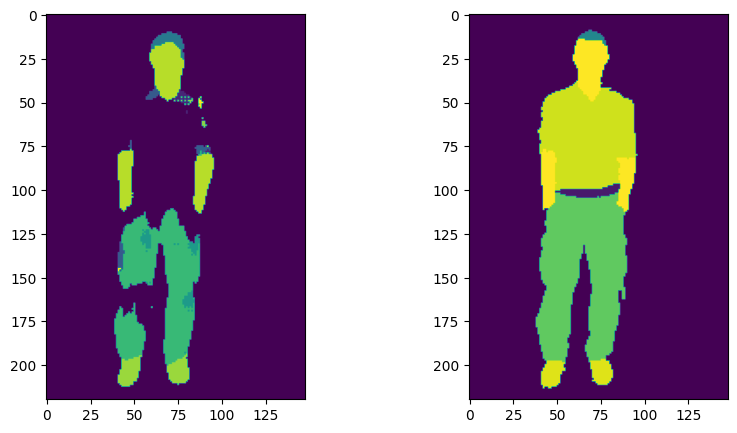

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_model_predicted_mask[max_iou_index,:,:,0])
plt.subplot(1,2,2)
plt.imshow(test_annotation[max_iou_index,:,:,0])
print("max_iou_index:",max_iou_index)
print("max_iou:",max_iou)

min_iou_index: 153
min_iou: 0.08116162


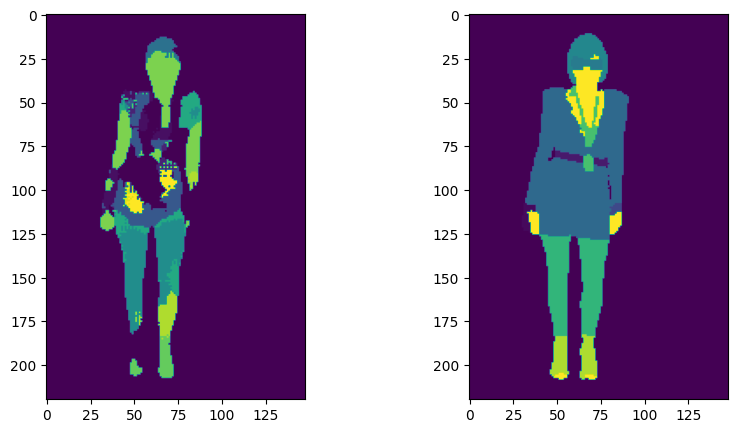

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_model_predicted_mask[min_iou_index,:,:,0])
plt.subplot(1,2,2)
plt.imshow(test_annotation[min_iou_index,:,:,0])
print("min_iou_index:",min_iou_index)
print("min_iou:",min_iou)

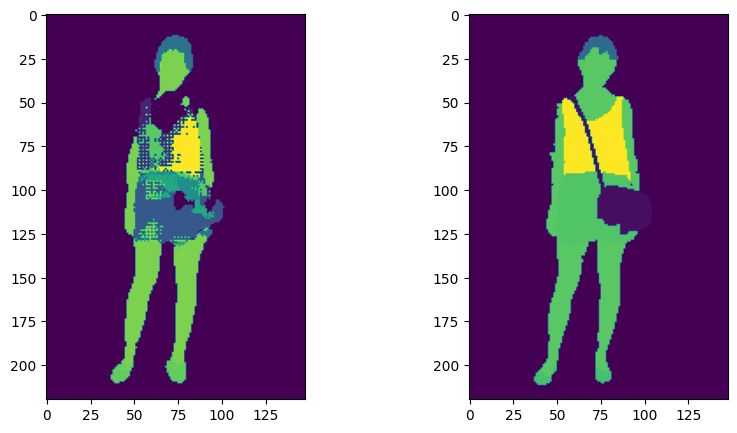

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(test_model_predicted_mask[7,:,:,0])
plt.subplot(1,2,2)
plt.imshow(test_annotation[7,:,:,0])